In [10]:
import os
import pandas
import h5py

import librosa.core as libcore
import numpy as np
from scipy.ndimage.interpolation import zoom
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
SAMPLING_RATE = 2048
N_FFT = 256
SEQ_TIME = 5

CHUNK_SIZE = SEQ_TIME * SAMPLING_RATE
HOP_LENGTH = N_FFT // 4
STFT_FPS = SAMPLING_RATE // HOP_LENGTH

TS_SIZE = 2500


In [3]:
def sample_chunk(samples, power, position=None, size=CHUNK_SIZE):
        
    if position is None:
        position = int(np.random.uniform(high=len(samples) - size))    
        
    chunk = samples[position : position + size] / power  
    
    spectrum = np.log(np.abs(libcore.stft(chunk, n_fft=N_FFT)) + 1)[0 : N_FFT // 4] / 10.0        
    spectrum = zoom(spectrum, zoom=0.5)
    return spectrum



In [11]:
signals ={}
powers ={}

for f in tqdm(os.listdir('Clean/')):
    samples, _ = libcore.load('Clean/' + f, sr=SAMPLING_RATE)
    power = np.mean(samples ** 2) * 0.5
    signals[f] = samples
    powers[f] = power

100%|██████████| 75/75 [04:48<00:00,  3.84s/it]  


In [28]:
signals.values()

dict_values([array([ 3.5709345e-05,  4.0758434e-05,  4.3330267e-05, ...,
       -5.3308751e-05, -4.5050681e-05, -3.1591138e-05], dtype=float32), array([-1.5851228e-04, -1.6326469e-04, -1.5752942e-04, ...,
       -6.1610795e-06, -3.5567798e-06, -8.7636909e-07], dtype=float32), array([-6.0527494e-05, -5.4572949e-05, -4.3947861e-05, ...,
       -1.6874503e-04, -1.3418563e-04, -8.6230320e-05], dtype=float32), array([-2.9076534e-04, -2.3755003e-04, -1.6181683e-04, ...,
       -7.1148565e-06, -6.1258488e-06, -4.5181687e-06], dtype=float32), array([-1.4651438e-06, -7.2236735e-06, -1.3489274e-05, ...,
        1.4512508e-05,  9.6788699e-06,  4.3555387e-06], dtype=float32), array([2.8737411e-05, 2.3289134e-05, 1.5833926e-05, ..., 1.0116734e-05,
       8.3695923e-06, 5.7416996e-06], dtype=float32), array([6.3790030e-05, 6.4431631e-05, 6.0738384e-05, ..., 4.0755916e-05,
       4.7133315e-05, 4.5255838e-05], dtype=float32), array([1.06431537e-04, 1.31476365e-04, 1.49954416e-04, ...,
       2.302679

In [79]:
training_set = np.array([sample_chunk(list(signals.values())[i],list(powers.values())[i]).T for i in range(len(os.listdir('Clean'))) for _ in range(1000)])


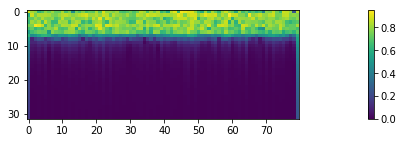

In [80]:
plt.figure(figsize=(25,2))
cax = plt.imshow(training_set[74].T)
plt.colorbar(cax)
plt.show()
plt.close()


In [81]:
from keras.layers import Input,LSTM
from keras.layers.core import RepeatVector
from keras.models import Sequential
from keras.models import Model

In [82]:
SEQ_LEN = (SEQ_TIME * STFT_FPS + 1) // 2
INPUT_DIM = (N_FFT // 4) // 2

# input layer
inputs = Input(shape=(SEQ_LEN, INPUT_DIM))

#encoder 
enc = LSTM(100, activation ='relu')(inputs)

# feature layer  with repeat vector
features =RepeatVector(SEQ_LEN)(enc)

#decoder layer
dec = LSTM(INPUT_DIM, activation ='relu',return_sequences =True)(features)

autoencoder =Model(inputs, dec)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 80, 32)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 100)               53200     
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 80, 100)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 80, 32)            17024     
Total params: 70,224
Trainable params: 70,224
Non-trainable params: 0
_________________________________________________________________


In [83]:
autoencoder.compile(optimizer='sgd', loss='mse')

In [85]:
from keras.callbacks import ModelCheckpoint

model_cb = ModelCheckpoint('output/lstm-{epoch:d}-{val_loss:.3f}.hdf', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=10)
history = autoencoder.fit(training_set, training_set, epochs=10, validation_split=0.1, callbacks=[model_cb])

Train on 67500 samples, validate on 7500 samples
Epoch 1/10
67500/67500 [==============================] - 208s 3ms/step - loss: 0.0719 - val_loss: 0.0706
Epoch 2/10
67500/67500 [==============================] - 212s 3ms/step - loss: 0.0661 - val_loss: 0.0702
Epoch 3/10
67500/67500 [==============================] - 205s 3ms/step - loss: 0.0657 - val_loss: 0.0699
Epoch 4/10
67500/67500 [==============================] - 212s 3ms/step - loss: 0.0655 - val_loss: 0.0697
Epoch 5/10
67500/67500 [==============================] - 203s 3ms/step - loss: 0.0652 - val_loss: 0.0695
Epoch 6/10
67500/67500 [==============================] - 198s 3ms/step - loss: 0.0651 - val_loss: 0.0693
Epoch 7/10
67500/67500 [==============================] - 202s 3ms/step - loss: 0.0649 - val_loss: 0.0692
Epoch 8/10
67500/67500 [==============================] - 199s 3ms/step - loss: 0.0648 - val_loss: 0.0691
Epoch 9/10
67500/67500 [==============================] - 198s 3ms/step - loss: 0.0647 - val_loss: 0.06

In [86]:
batch_size = 10
batch_input = sample_chunk(samples, power, position=0, size=CHUNK_SIZE * (batch_size + 1))
print(batch_input.shape)

stride = SEQ_LEN // 4 

batch = np.array([batch_input[:, i * stride : i * stride + SEQ_LEN].T for i in range(batch_size * 4)])
print(batch.shape)
prediction = autoencoder.predict(batch)

batch_output = None
for i, chunk in enumerate(prediction):            
    if batch_output is None:        
        batch_output = np.array(chunk[: stride + 10])
    else:                
        batch_output = np.concatenate((batch_output, chunk[10 : stride + 10]))

(32, 880)
(40, 80, 32)


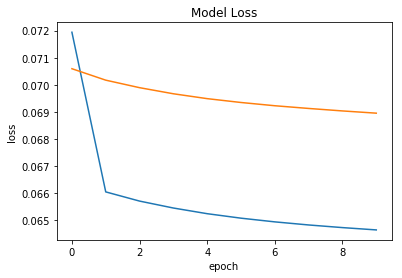

<Figure size 432x288 with 0 Axes>

In [87]:
# plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.savefig('model_loss.png')

In [73]:
batch_output.shape

(810, 32)

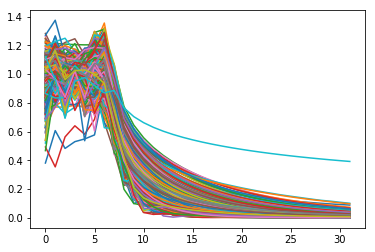

In [89]:
plt.plot(batch_input)
plt.show()

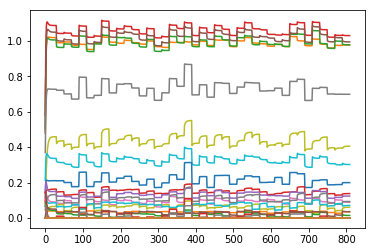

In [90]:
plt.plot(batch_output)
plt.show()